In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv
/kaggle/input/creditcardfraud/creditcard.csv



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>About Dataset<strong></font></h1>

## Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Content
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Update (03/05/2021)
A simulator for transaction data has been released as part of the practical handbook on Machine Learning for Credit Card Fraud Detection - https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html. We invite all practitioners interested in fraud detection datasets to also check out this data simulator, and the methodologies for credit card fraud detection presented in the book.

## Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>Imports<strong></font></h1>

In [2]:
!pip install LazyPredict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    confusion_matrix, classification_report
)
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, 
    GradientBoostingClassifier, RandomForestClassifier
)
from sklearn.linear_model import (
    LogisticRegression, PassiveAggressiveClassifier, Perceptron, 
    RidgeClassifier, RidgeClassifierCV, SGDClassifier
)
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.style.use('ggplot')



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>Data Overview<strong></font></h1>

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [5]:
df['Time'].describe()

count   284807.00
mean     94813.86
std      47488.15
min          0.00
25%      54201.50
50%      84692.00
75%     139320.50
max     172792.00
Name: Time, dtype: float64

172792 is max value of Time column , therefore We have data of 1 day 23 hour 59 minutes and 52 seconds

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

since v1-v28 are the transformed columns using PCA , there is no point in understanding the details of the columns.


<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>EDA<strong></font></h1>

In [8]:
pip install --upgrade plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.18.0
    Uninstalling plotly-5.18.0:
      Successfully uninstalled plotly-5.18.0
Note: you may need to restart the kernel to use updated packages.


In [9]:
import plotly.express as px 
fig = px.pie(data_frame = df,names = 'Class',title = 'Distribution of Classes',)

In [10]:
fig.show()

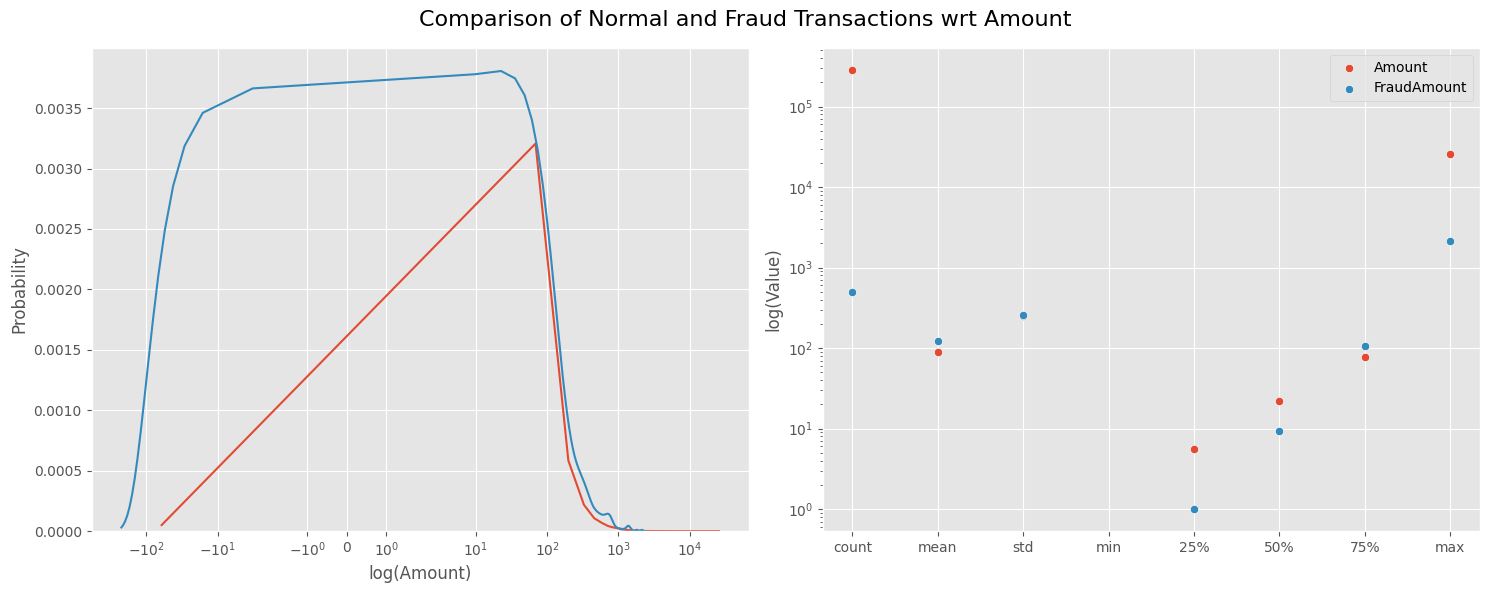

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,6))
fig.suptitle('Comparison of Normal and Fraud Transactions wrt Amount', fontsize=16)


sns.kdeplot(df[df['Class'] == 0]['Amount'], label='Amount',ax = ax[0])
sns.kdeplot(df[df['Class'] == 1]['Amount'], label='FraudAmount',ax = ax[0])
ax[0].set_xscale('symlog')
ax[0].set_xlabel('log(Amount)')
ax[0].set_ylabel('Probability')
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(df[df['Class'] == 0]['Amount'].describe(), label='Amount',ax = ax[1])
sns.scatterplot(df[df['Class'] == 1]['Amount'].describe(), label='FraudAmount',ax = ax[1])
ax[1].set_yscale('log')
ax[1].set_xlabel('')
ax[1].set_ylabel('log(Value)')
plt.tight_layout()
plt.show()

**- Note: for low amount transactions , the probability of fraud is more than a regular transaction , but most of the transactions are normal so it is not a good idea to draw any conclusion incase of imbalanced dataset.**

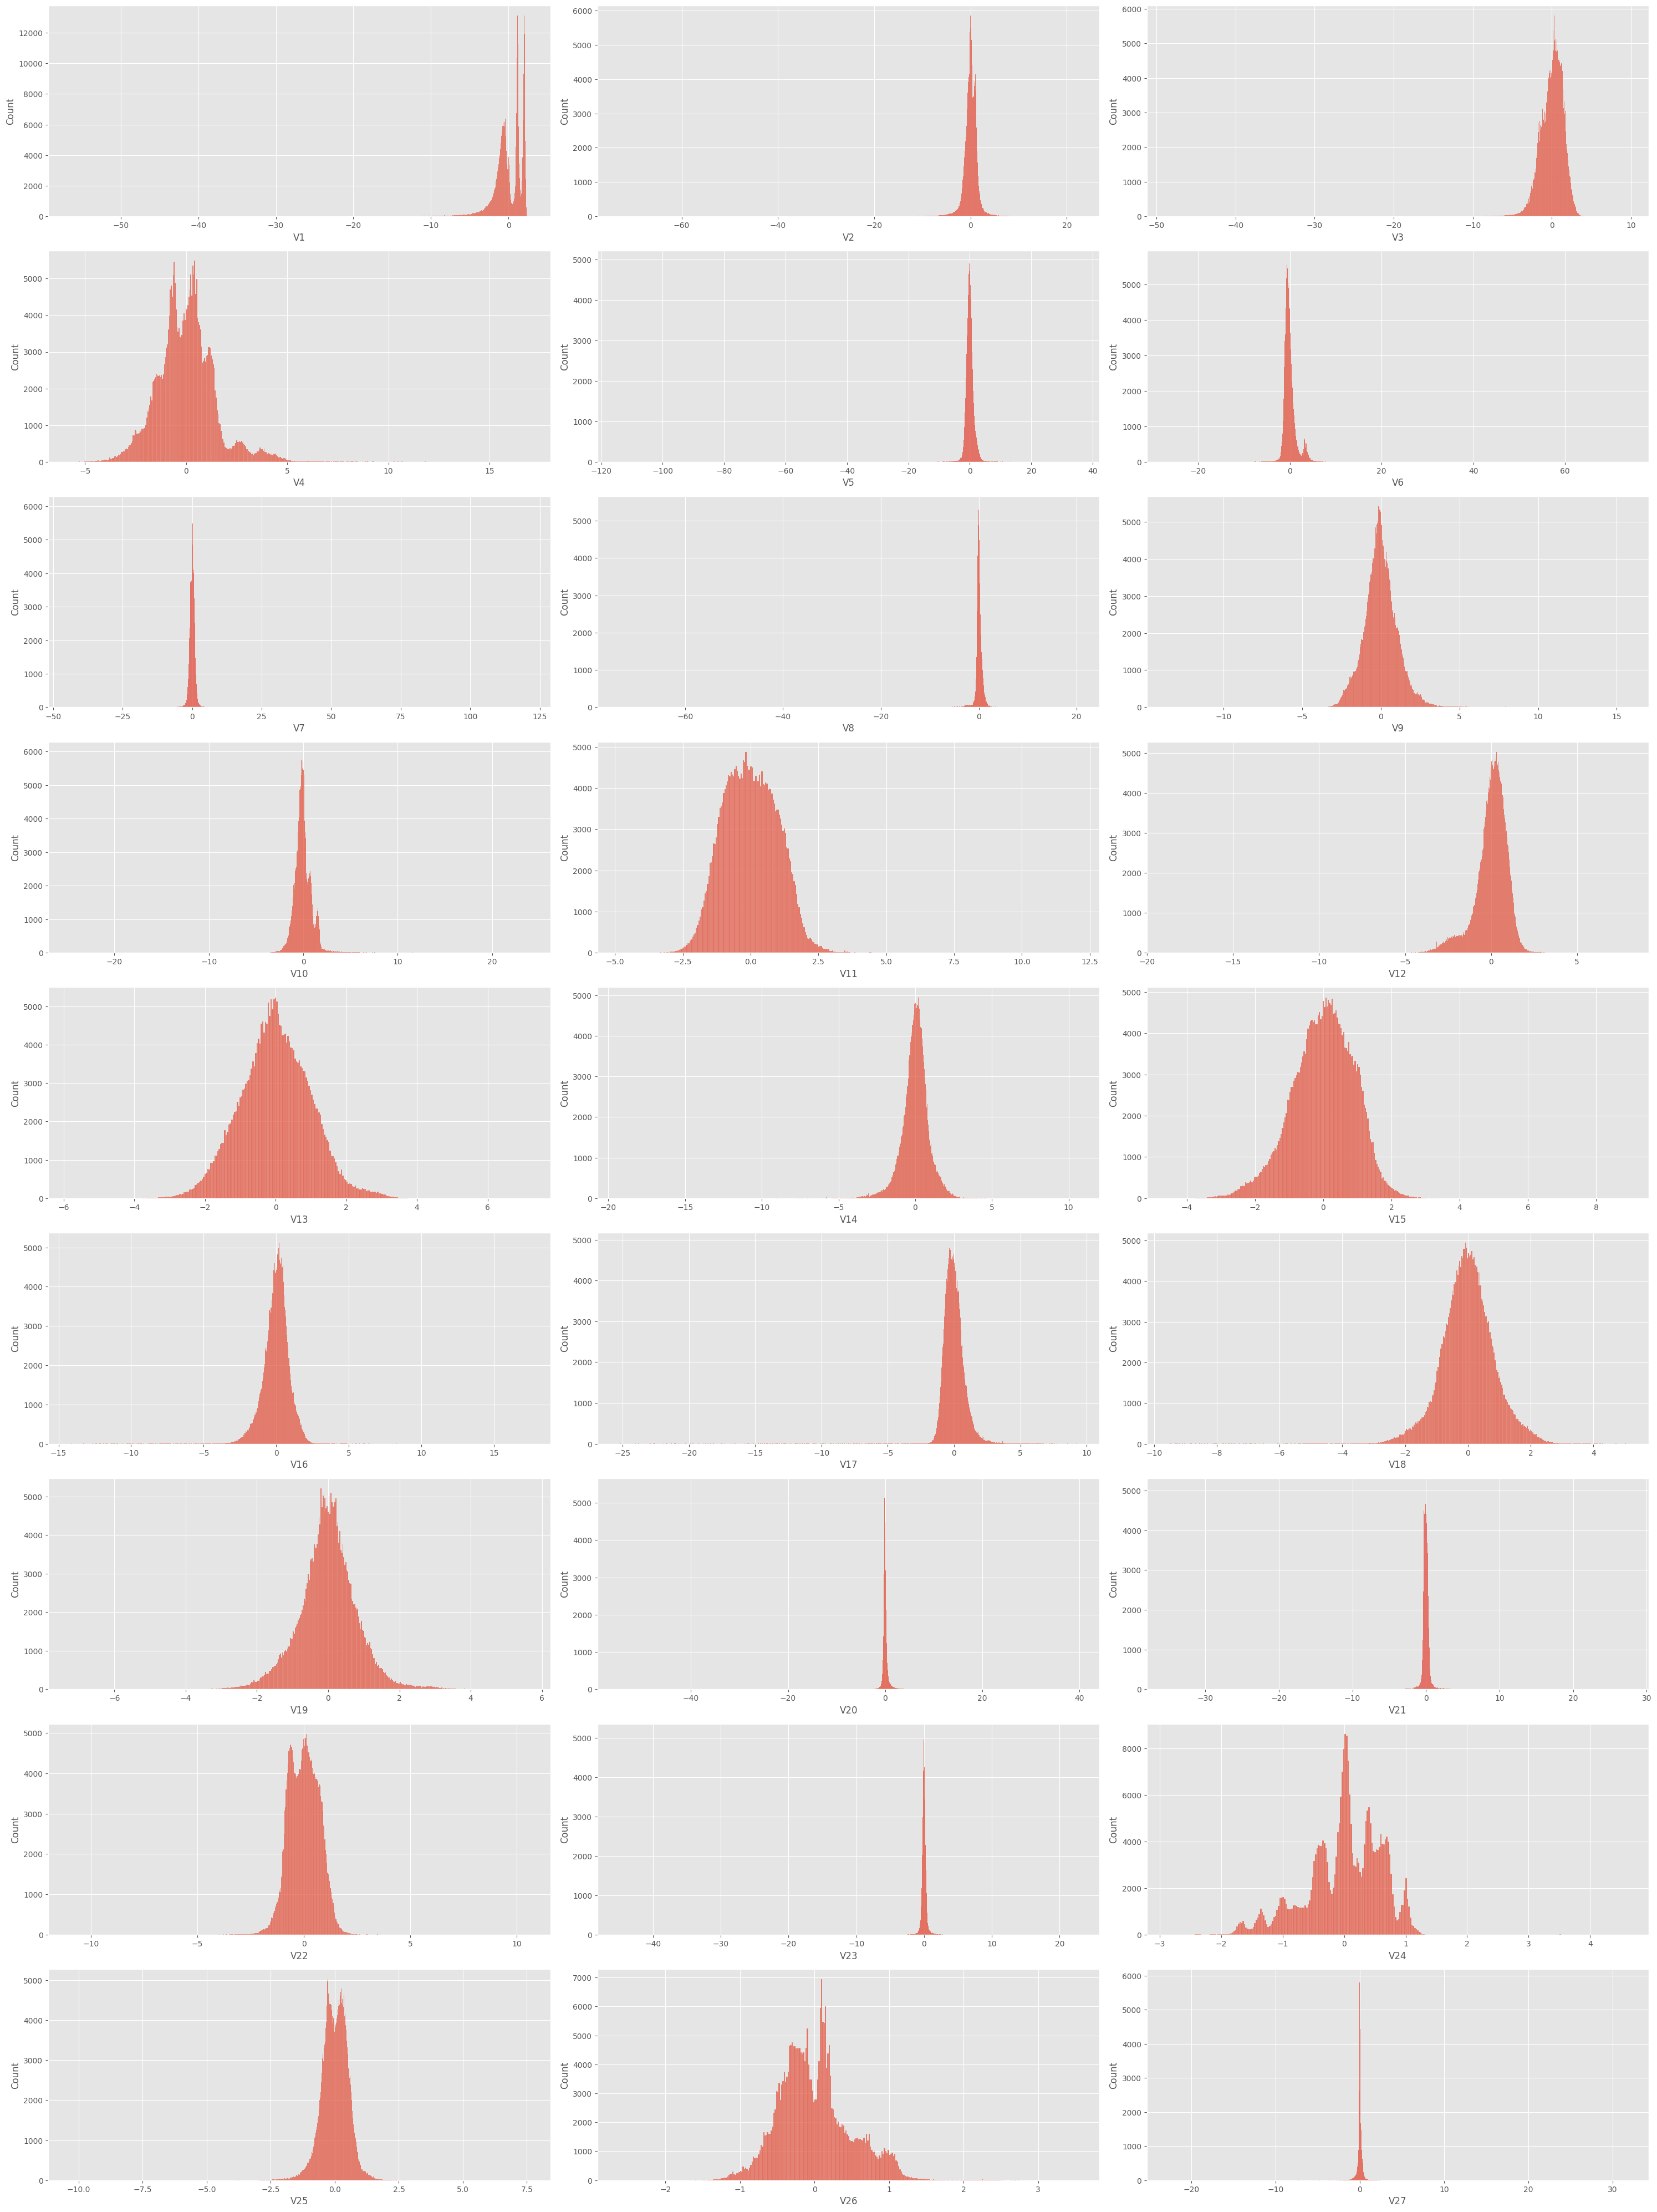

In [12]:
fig,ax = plt.subplots(9,3,figsize=(30,40))
ax = ax.flatten()
for i,column in enumerate(df.columns[1:28]):

    sns.histplot(data = df, x = df[column],ax = ax[i])
plt.tight_layout()    
plt.show()


<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>Feature Selection using correlation<strong></font></h1>

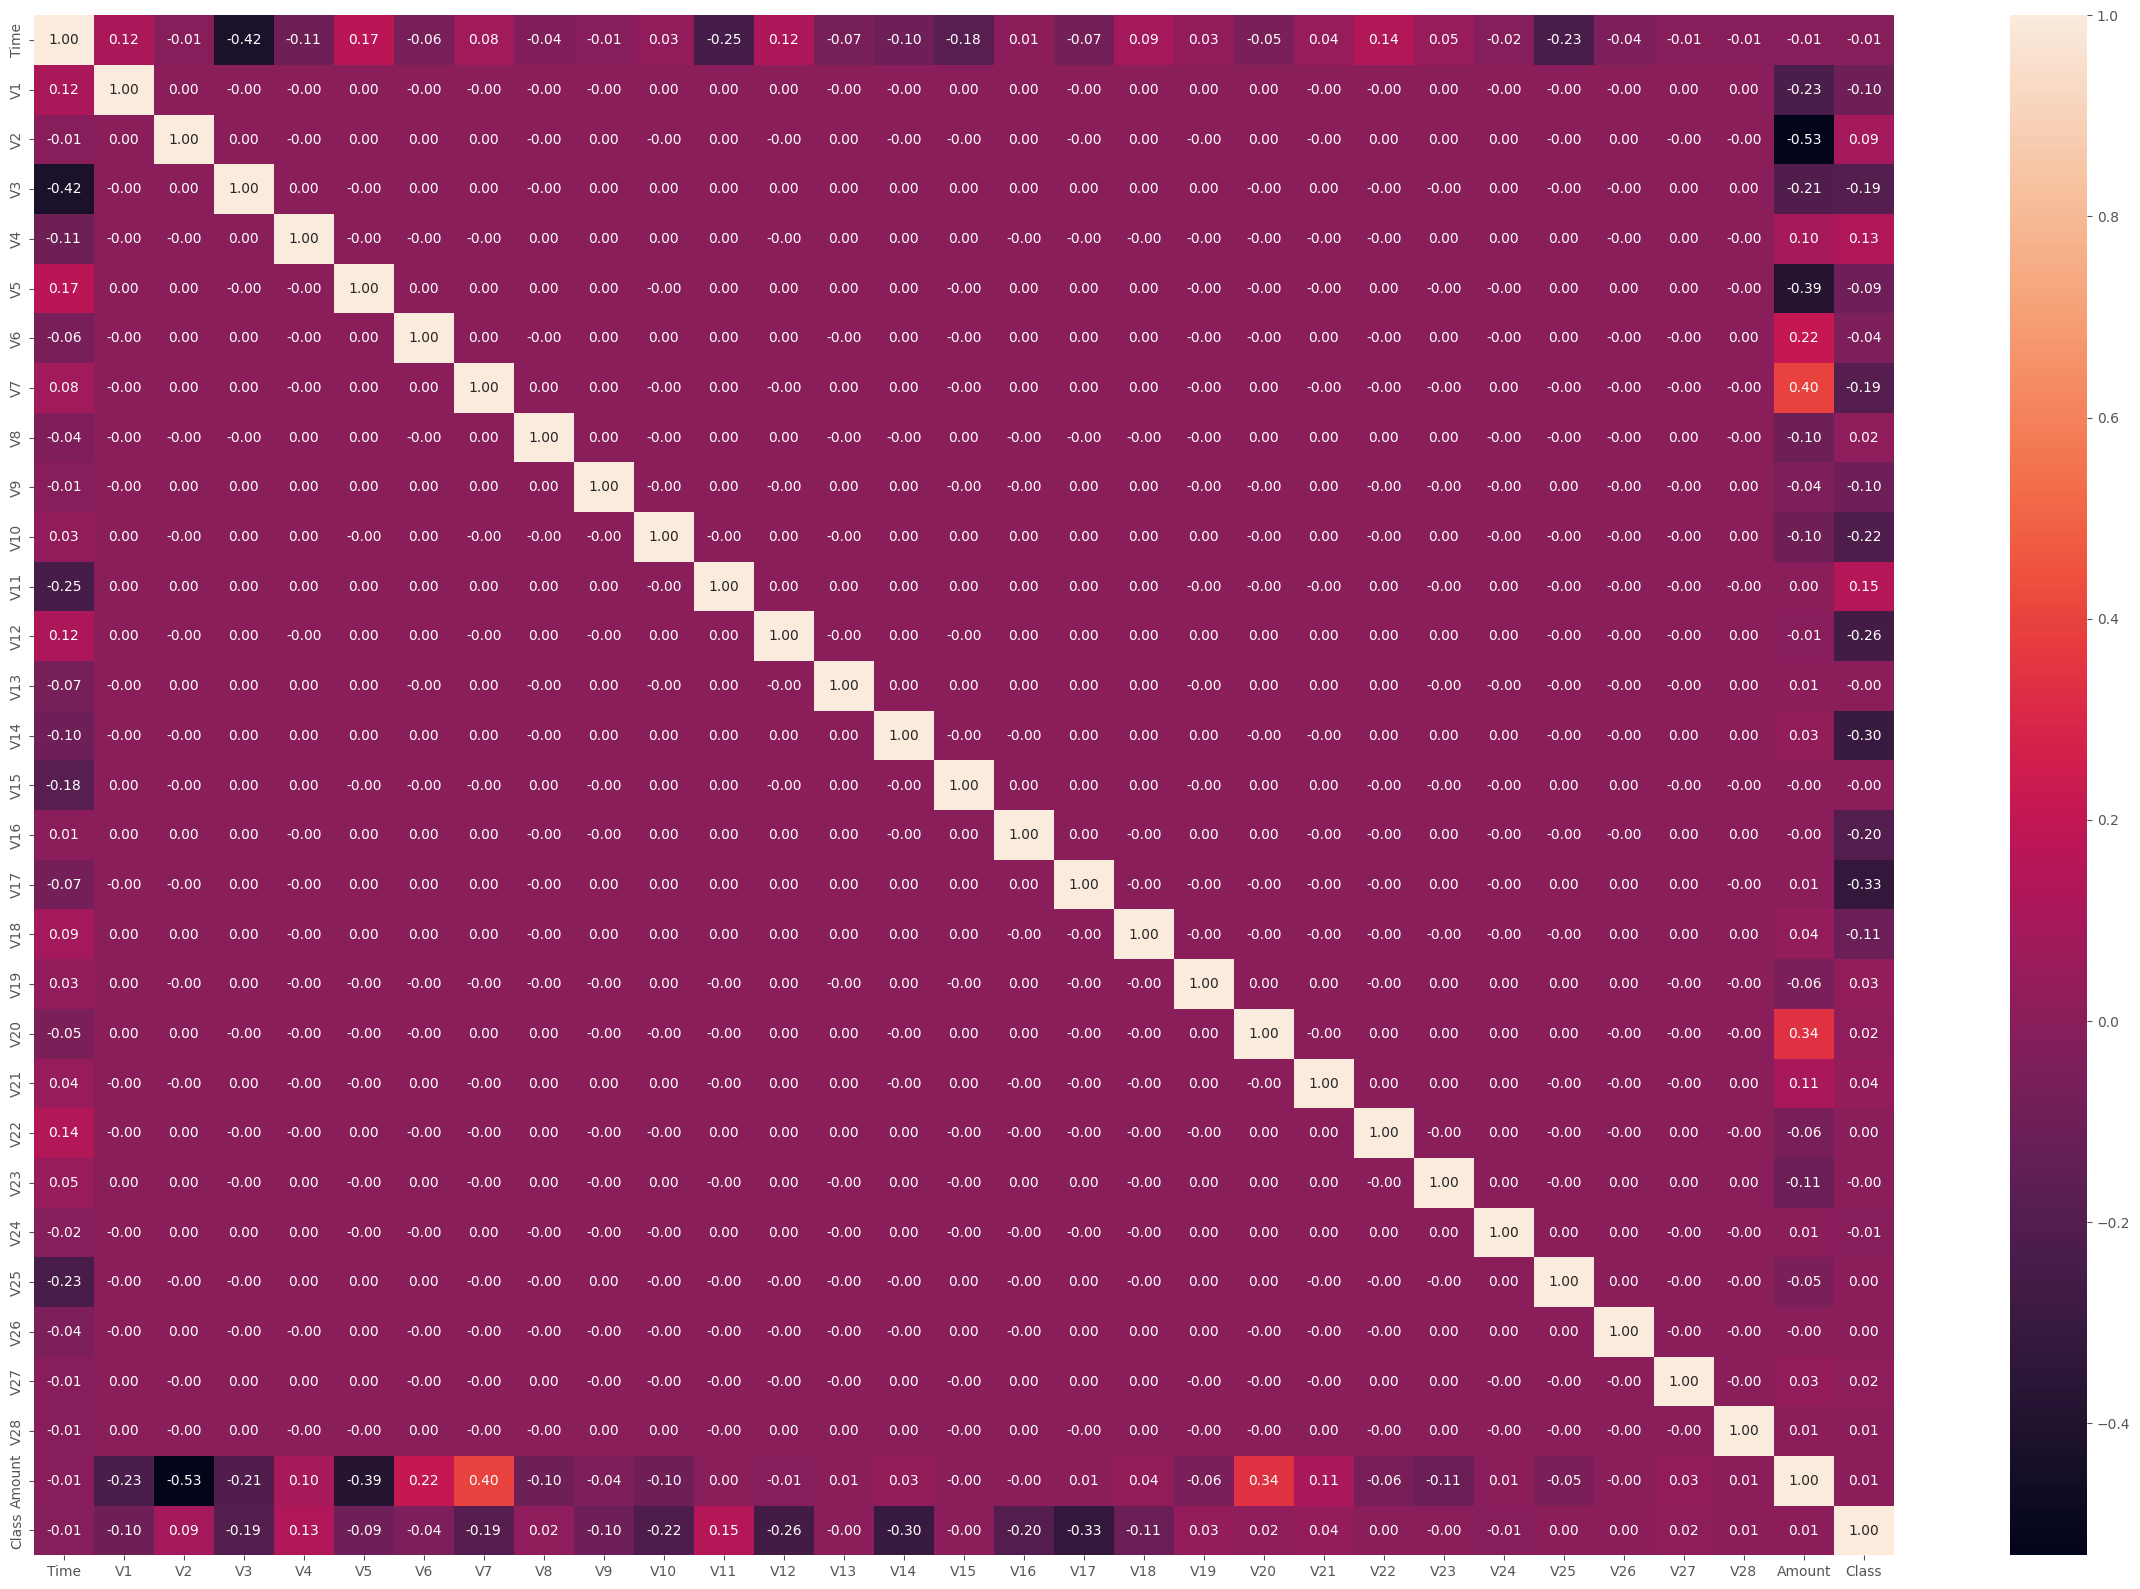

In [13]:
plt.figure(figsize=(30,20))
sns.heatmap(df.corr(),cbar = 'coolwarm', annot = True, fmt = "0.2f")

# dropping the columns having correlation less than 0.10.
# i will try whole data set and selected columns both one by one during model building.

for corr,column in zip(df.corr().iloc[30],df.columns):
    if abs(corr)<0.13:
        df.drop(columns = column , inplace = True)
    

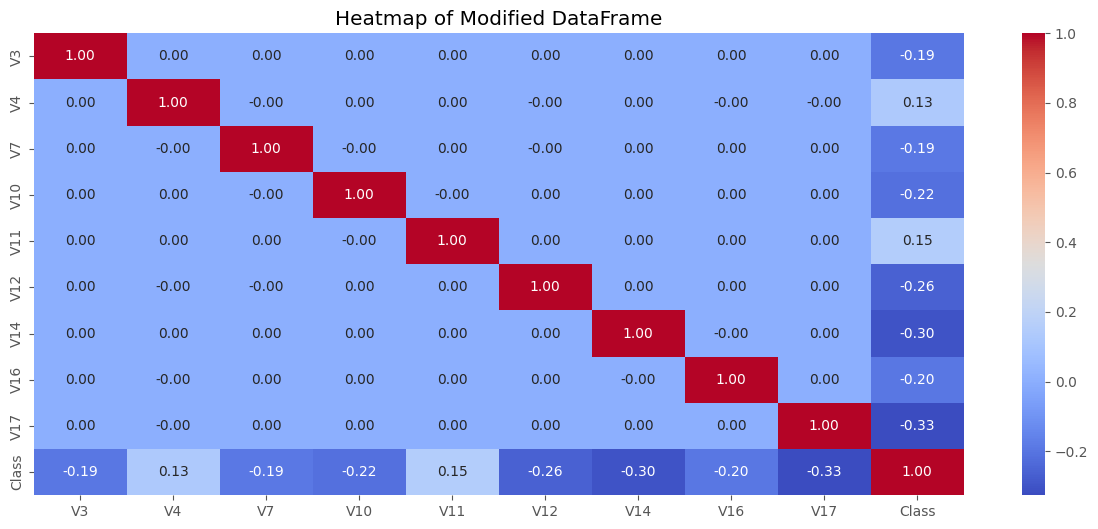

In [14]:
plt.figure(figsize=(15,6))
plt.title('Heatmap of Modified DataFrame')
sns.heatmap(df.corr(),cmap='coolwarm',fmt='0.2f',annot = True)
plt.show()

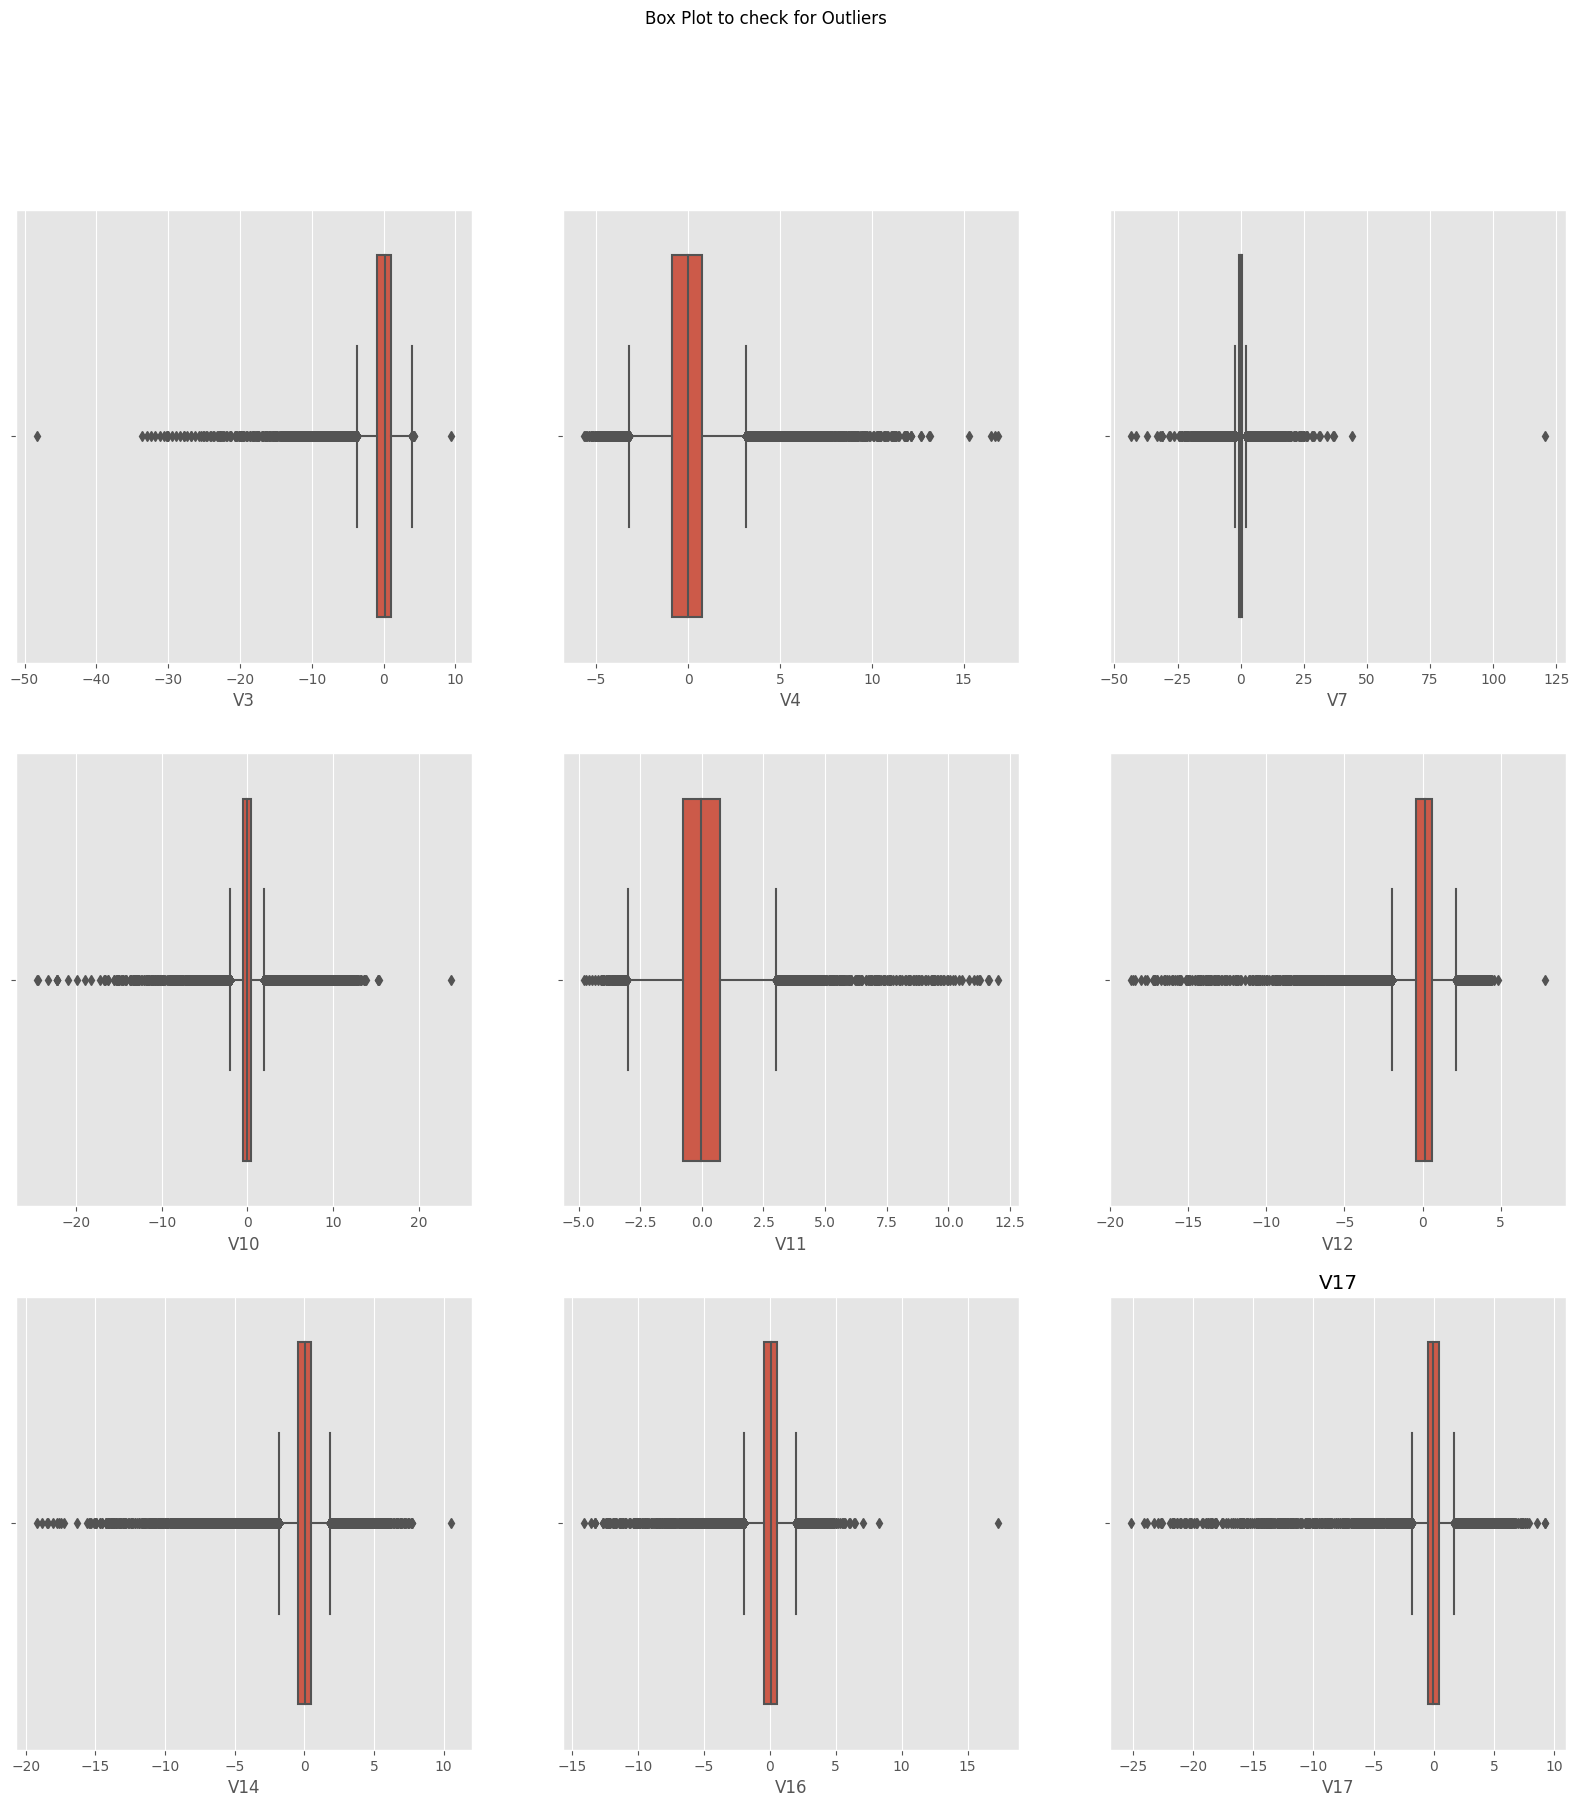

In [15]:
fig,ax = plt.subplots(3,3,figsize=(20,20))
ax = ax.flatten()
plt.suptitle('Box Plot to check for Outliers')
for i,column in enumerate(df.columns):
    if i ==9:
        continue
    sns.boxplot(data = df , x = column, ax = ax[i])
    plt.title(column)

In [16]:
# splitting the data to apply different techniques of handling imbalance data on training set .(To prevent Data leakage i am not using whole Dataset)
X = df.drop(columns = ['Class'])
y = df['Class']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
print(f' shape of X_train is {X_train.shape}, shape of X_test is {X_test.shape}, shape of y_train is {y_train.shape}, shape of y_test is {y_test.shape}')

 shape of X_train is (227845, 9), shape of X_test is (56962, 9), shape of y_train is (227845,), shape of y_test is (56962,)



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>DownSampling<strong></font></h1>

In [17]:
# honestly i checked different Sampling Techniques (undersampling, oversampling, combination of both (SMOTEENN) but UnderSampling is best approach for this data)
# problem with Oversampling - Class - 1 Data is very less therefore synthetically generated Data isnot the representation of the actual Data .  generating 
# more than 800,000 samples from 492 samples is probably a huge mistake.
# therefore i have used RandomUnderSampler for undersampling .


In [18]:
rus = RandomUnderSampler(random_state = 7)
X_res, y_res = rus.fit_resample(X_train, y_train)

print(f' shape of X_res_rus is {X_res.shape}, shape of y_res_rus is {y_res.shape}')
print(f'Distribution of y_res_rus: {Counter(y_res)}')


 shape of X_res_rus is (788, 9), shape of y_res_rus is (788,)
Distribution of y_res_rus: Counter({0: 394, 1: 394})


In [19]:
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_res, X_test, y_res, y_test)

# lazyPredict used weighted f1_Score , which is misleading in case of imbalanced Data 
# f1 = f1_score(y_test, y_pred, average='weighted') ---> i pasted this from there original Code.

 97%|█████████▋| 28/29 [00:12<00:00,  3.78it/s]

[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:13<00:00,  2.12it/s]


In [20]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SGDClassifier,0.97,0.95,0.95,0.98,0.17
SVC,0.99,0.95,0.95,0.99,0.57
LogisticRegression,0.98,0.95,0.95,0.99,0.17
CalibratedClassifierCV,0.99,0.95,0.95,0.99,0.26
ExtraTreesClassifier,0.97,0.95,0.95,0.99,0.84
LabelSpreading,0.97,0.94,0.94,0.98,1.31
KNeighborsClassifier,0.98,0.94,0.94,0.99,3.22
LabelPropagation,0.97,0.94,0.94,0.98,1.42
LinearSVC,0.97,0.94,0.94,0.99,0.17



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>Checking All The Models Performance <strong></font></h1>

In [21]:
#  I have Listed all models for easier access

models = {
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "LabelPropagation": LabelPropagation(),
    "LabelSpreading": LabelSpreading(),
    "LGBMClassifier": LGBMClassifier(),
    "LinearSVC": LinearSVC(),
    "CalibratedClassifierCV": CalibratedClassifierCV(),
    "RandomForestClassifier": RandomForestClassifier(),
    "SGDClassifier": SGDClassifier(),
    "LogisticRegression": LogisticRegression(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "Perceptron": Perceptron(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "BaggingClassifier": BaggingClassifier(),
    "NuSVC": NuSVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RidgeClassifier": RidgeClassifier(),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "ExtraTreeClassifier": ExtraTreeClassifier(),
    "NearestCentroid": NearestCentroid(),
    "RidgeClassifierCV": RidgeClassifierCV(),
    "PassiveAggressiveClassifier": PassiveAggressiveClassifier(),
    "DummyClassifier": DummyClassifier()
}

results = {
    "Model": [],
    "Accuracy": [],
    "F1 Score Weighted": [],
    "F1 Score Macro": [],
    "Precision_weighted": [],
    "Recall_weighted": [],
    "Precision_macro_avg": [],
    "Recall_macro_avg": []
    
}


for model_name, model in models.items():

    model.fit(X_res, y_res)
    
    y_pred = model.predict(X_test)
    
    results["Model"].append(model_name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["F1 Score Weighted"].append(f1_score(y_test, y_pred, average='weighted'))
    results["F1 Score Macro"].append(f1_score(y_test, y_pred, average='macro'))
    results["Precision_weighted"].append(precision_score(y_test, y_pred, average='weighted'))
    results["Recall_weighted"].append(recall_score(y_test, y_pred, average='weighted'))
    results["Precision_macro_avg"].append(precision_score(y_test, y_pred, average='macro'))
    results["Recall_macro_avg"].append(recall_score(y_test, y_pred, average='macro'))


results_df = pd.DataFrame(results)


[LightGBM] [Info] Number of positive: 394, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 788, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [22]:
results_df

,Model,Accuracy,F1 Score Weighted,F1 Score Macro,Precision_weighted,Recall_weighted,Precision_macro_avg,Recall_macro_avg
0,ExtraTreesClassifier,0.98,0.99,0.55,1.00,0.98,0.53,0.95
1,LabelPropagation,0.94,0.97,0.51,1.00,0.94,0.51,0.91
2,LabelSpreading,0.94,0.97,0.51,1.00,0.94,0.51,0.91
3,LGBMClassifier,0.95,0.97,0.52,1.00,0.95,0.52,0.93
4,LinearSVC,0.97,0.98,0.55,1.00,0.97,0.53,0.95
5,CalibratedClassifierCV,1.00,1.00,0.76,1.00,1.00,0.68,0.94
6,RandomForestClassifier,0.96,0.98,0.53,1.00,0.96,0.52,0.94
7,SGDClassifier,0.96,0.98,0.52,1.00,0.96,0.52,0.94
8,LogisticRegression,0.97,0.98,0.54,1.00,0.97,0.52,0.95
9,KNeighborsClassifier,0.98,0.99,0.56,1.00,0.98,0.53,0.94



<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong>Final Model<strong></font></h1>
    <font color=#000000><strong>Model Choice Depends on the requirements , thats why i have listed the metrics for all the Models Above , For this Notebook I will use the Model with highest F1 Score(i.e.NearestCentroid).<strong></font>

In [23]:

FinalModel = NearestCentroid()
FinalModel.fit(X_res, y_res)
pred = FinalModel.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



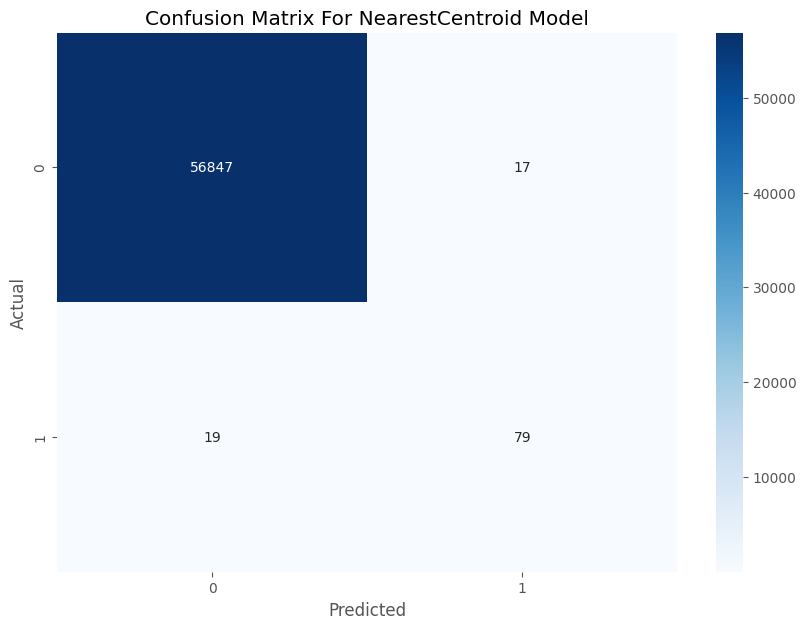

In [24]:
conf_matrix = confusion_matrix(y_test, pred)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For NearestCentroid Model')
plt.show()

<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    
<h1 align="center"><font color=#FF0000><strong> Version 8 : Trying ANN<strong></font></h1>
    <font color=#000000><strong>.<strong></font>

# Neural Network Model

In [25]:
import tensorflow
from tensorflow import keras
from keras.layers import Dense,BatchNormalization,Dropout
from keras import Sequential

Model = Sequential()
Model.add(Dense(9,activation = 'relu',input_dim = 9))
Model.add(Dense(16,activation = 'relu'))
Model.add(Dropout(0.2))
Model.add(Dense(16,activation = 'relu'))
Model.add(Dropout(0.2))
Model.add(Dense(1,activation = 'sigmoid'))

Model.compile(loss = 'binary_crossentropy',weighted_metrics=['f1_score','recall','precision'])

history = Model.fit(X_res,y_res,epochs = 100)

2024-07-26 11:58:07.484667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 11:58:07.484781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 11:58:07.630769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.6616 - loss: 0.6598 - precision: 0.6259 - recall: 0.5766
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6755 - loss: 0.5272 - precision: 0.6763 - recall: 0.8755  
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6410 - loss: 0.4594 - precision: 0.7462 - recall: 0.8948 
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6895 - loss: 0.4067 - precision: 0.8076 - recall: 0.8799 
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6738 - loss: 0.3532 - precision: 0.8923 - recall: 0.8673 
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6898 - loss: 0.2991 - precision: 0.9515 - recall: 0.8876 
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6790 - loss: 0.2805 - precision: 0.9311 - recall: 0.8813 
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.6605 - loss: 0.2653 - precision: 0.9650 - recall: 0.8817 
Epoch 9/100
25/2


<div style = "background-color: #dfe6e3; font-size:150%; text-align:left; border: 7px solid #3449eb; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.3);font-family : calibri ; border-radius : 20px 20px 20px 20px; padding: 10px; width:95%">
    <font color=#000000;><strong> Threshold value can be changed for Precision-Recall Trade-off   <strong></font>

In [26]:
threshold = 0.99999
pred_n = np.where(Model.predict(X_test)>threshold,1,0)
print(classification_report(y_test,pred))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.81      0.81        98

    accuracy                           1.00     56962
   macro avg       0.91      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962



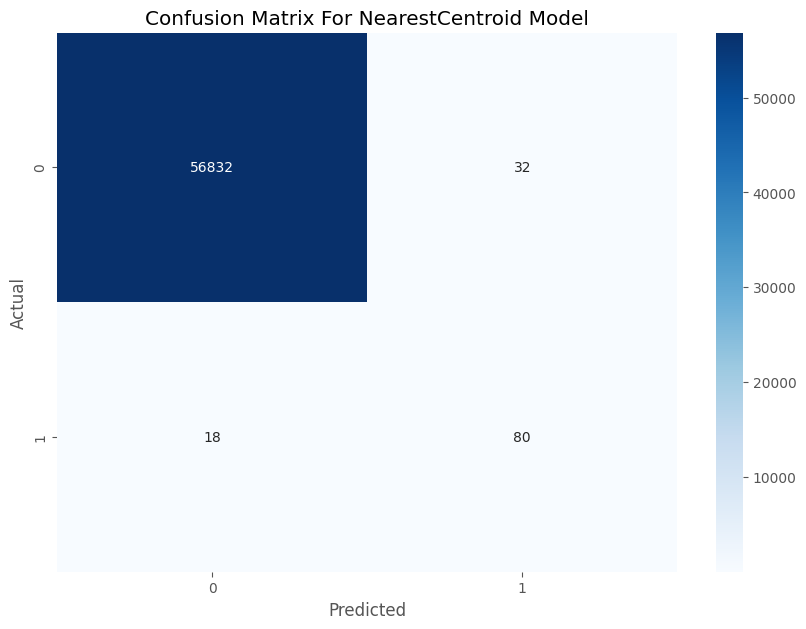

In [27]:
conf_matrix = confusion_matrix(y_test, pred_n)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For NearestCentroid Model')
plt.show()

* Thanks to Rabie El Kharoua for his Detailed Work on this DataSet.
<a href = 'https://www.kaggle.com/code/rabieelkharoua/fraudfighter-detecting-credit-card-fraud-ac-97'> Notebook link </a>
* I have used Cell Markdown code from
<a href ='https://www.kaggle.com/ziishan'>  Zeeshan Ahmed</a>

<h3 style="text-align:center;">Please Upvote this notebook if you found it helpful</h3>
<img src="https://media1.giphy.com/media/2lQCBjuFMLCOvXno4l/giphy.gif" alt="GIF" style="height: 300px; width: auto;margin:auto;">
